# SPEECH RECOGNITION

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import librosa
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Set your dataset directory and emotion labels

In [131]:
dataset_dir = '/kaggle/input/radwips'
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Load and preprocess audio data

In [132]:
def preprocess_audio(file_path, num_mfcc=13, max_frames=504):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
    
    # Pad or truncate MFCCs to have a consistent number of time steps
    if mfccs.shape[1] < max_frames:
        pad_width = max_frames - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)))
    else:
        mfccs = mfccs[:, :max_frames]
    
    return mfccs

Create sample dataset

In [133]:
data = []
labels = []

for emotion_label in emotion_labels:
    emotion_dir = os.path.join(dataset_dir, emotion_label)
    for audio_file in os.listdir(emotion_dir):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(emotion_dir, audio_file)
            features = preprocess_audio(audio_path)
            data.append(features)
            labels.append(emotion_labels.index(emotion_label))

data = np.array(data)
labels = np.array(labels)

Split data into training and validation sets

In [134]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

Create a CNN model

In [136]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [137]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [138]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))
    conv_3 = Convolution(conv_2, 128, (3,3))
    
    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten,256)
    
    output = Dense(len(emotion_labels),activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['sparse_categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [139]:
input_shape = (x_train.shape[1], x_train.shape[2], 1)
model = model_fer(input_shape)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 13, 504, 1)]      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 504, 32)       320       
                                                                 
 batch_normalization_38 (Bat  (None, 13, 504, 32)      128       
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  (None, 13, 504, 32)       0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 6, 252, 32)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 6, 252, 32)        0   

Initializing Model

In [140]:
epochs = 20
steps_per_epoch = len(x_train)//64
validation_steps = len(x_val)//64

checkpoint = ModelCheckpoint("model_weights4.h5", monitor = "val_accuracy", save_weights_only = True, mode = "max", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]

Train the model

In [141]:
history = model.fit(
    x=x_train,  # Training data
    y=y_train,  # Training labels
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_val, y_val),  # Validation data
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20


2023-08-15 14:47:52.423849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_37/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/8 [=========================>....] - ETA: 0s - loss: 2.0722 - accuracy: 0.2752
Epoch 1: saving model to model_weights4.h5
8/8 [==============================] - 4s 99ms/step - loss: 2.0685 - accuracy: 0.2868 - val_loss: 62.6519 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 2/20
7/8 [=========================>....] - ETA: 0s - loss: 1.7581 - accuracy: 0.3487
Epoch 2: saving model to model_weights4.h5
8/8 [==============================] - 0s 60ms/step - loss: 1.7781 - accuracy: 0.3426 - val_loss: 62.2373 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 3/20
7/8 [=========================>....] - ETA: 0s - loss: 1.6134 - accuracy: 0.3676
Epoch 3: saving model to model_weights4.h5
8/8 [==============================] - 0s 65ms/step - loss: 1.6203 - accuracy: 0.3762 - val_loss: 44.8560 - val_accuracy: 0.1407 - lr: 0.0010
Epoch 4/20
7/8 [=========================>....] - ETA: 0s - loss: 1.4562 - accuracy: 0.4622
Epoch 4: saving model to model_weights4.h5
8/8 [==============================] - 0s 59m

Model Evaluation

In [142]:
model.evaluate(x_val,y_val)

5/5 [==============================] - 0s 10ms/step - loss: 1.6243 - accuracy: 0.4148


[1.6243195533752441, 0.4148148000240326]

Plotting loss

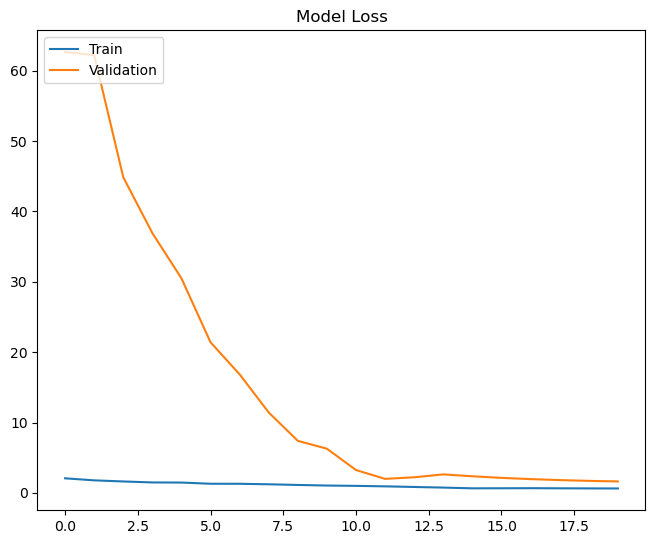

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

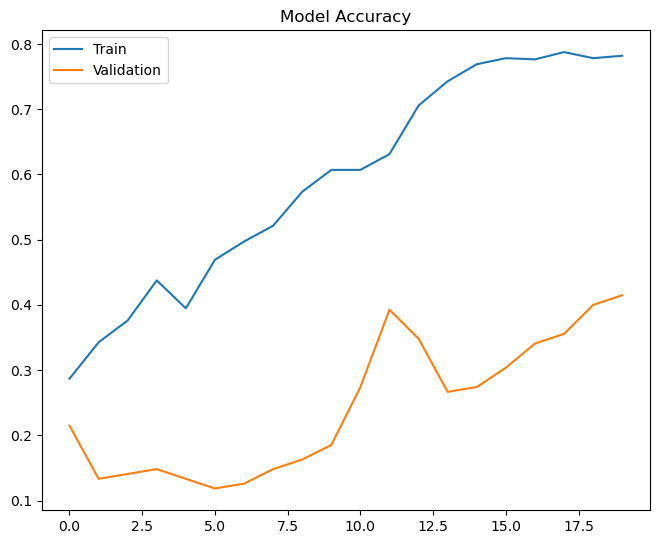

In [144]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

In [145]:
model_json = model.to_json()
with open("model_a4.json", "w") as json_file:
    json_file.write(model_json)